# Introduction
In this notebook I will try tuning the hyperparameters of a variety of machine learning algorithms using [Bayesian optimization](https://en.wikipedia.org/wiki/Bayesian_optimization#Applications). This strategy is well suited to optimizing functions for which you don't have a gradient and where the is a high computational cost associated with function evaluation.

BO is described thus on Wikipedia:

*Since the objective function is unknown, the Bayesian strategy is to treat it as a random function and place a prior over it. The prior captures beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criteria) that determines the next query point.*


 Given a machine learning algorithm (say LightGBM for example) and a set of hyperparameters, tuning amounts to minimizing a function which takes as its arguments a set of values for the hyperparameters, and returns the cross validation score for the model fitted on our training data with those parameters. This function clearly satisfies the above criteria for using Bayesian optimization. 

I will use the [GPyOpt](https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html) implementation of Bayesian optimization using the MPI (maximum probability of improvement) aquisition type.
The dataset I will use is a Kaggle competition [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) for house price prediction. There is a labeled training set and a test set for which predictions can be submitted to Kaggle.


First I will do some very basic EDA and create the training sets I need. Then, for each of 5 different algorithms (LightGBM, XGBoost, Random Forest, CatBoost and Neural networks) I will define the set of parameters I will tune and the ranges of values to be considered (which may be continuous or discrete). Next I create an objective functio - in each case I will use a root mean square (or equivalent) loss function for the underlying model. Then I will optimize the parameters using BO, fit the model to the training data with the optimal parameters and use the fitted model to make predictions on the test dataset which I then submit on Kaggle. For comparison I will also submit predictions from the same model fitted using the default parametrization. 
The goal here is not to minimze the submission score but to see how much the optimal parameters improve my submission.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

import warnings
warnings.filterwarnings("ignore")
!pip install catboost
from catboost import CatBoostRegressor
from catboost import cv as cat_boost_cv
from catboost import Pool

import lightgbm as lgb

! pip install GPy gpyopt xgboost
! pip uninstall Gpy
! pip install GPy==1.9.2

import GPy
import GPyOpt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor 

import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# EDA

First I do a quick dive into the data. For a more thorough description of the data see https://github.com/Dermot890/House-Price-Prediction

In [13]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
submission_df = pd.read_csv('/content/drive/My Drive/House Price Competition/sample_submission.csv')
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to  0.57 Mb (36.4% reduction)
Mem. usage decreased to  0.57 Mb (35.8% reduction)


In [14]:
#missing features
train_df[train_df.columns[np.where(np.sum(train_df.isnull())>0)[0]]].isnull().sum()
train_df.loc[train_df.LotFrontage.isnull(),'LotFrontage']  = 0;train_df.loc[train_df.Fence.isnull(),'Fence']  = 'NF'
train_df.loc[train_df.Alley.isnull(),'Alley']  = 'NA';train_df.loc[train_df.GarageType.isnull(),'GarageType']  = 'NG'
train_df.loc[train_df.GarageFinish.isnull(),'GarageFinish']  = 'NG';train_df.loc[train_df.GarageCond.isnull(),'GarageCond']  = 'NG'
train_df.loc[train_df.GarageQual.isnull(),'GarageQual']  = 'NG';train_df.loc[train_df.GarageType.isnull(),'GarageType']  = 'NG'
train_df.loc[train_df.GarageYrBlt.isnull(),'GarageYrBlt']  = 0;train_df.loc[train_df.BsmtFinType1.isnull(),'BsmtFinType1']  = 'NB'
train_df.loc[train_df.BsmtQual.isnull(),'BsmtQual']  = 'NB';train_df.loc[train_df.BsmtCond.isnull(),'BsmtCond']  = 'NB'
train_df.loc[train_df.BsmtExposure.isnull(),'BsmtExposure']  = 'NB';train_df.loc[train_df.BsmtFinType2.isnull(),'BsmtFinType2']  = 'NB'
train_df.loc[train_df.MasVnrType.isnull(),'MasVnrType']  = 'none';train_df.loc[train_df.MasVnrArea.isnull(),'MasVnrArea']  = 0
train_df.loc[train_df.PoolQC.isnull(),'PoolQC']  = 'NP';train_df.loc[train_df.FireplaceQu.isnull(),'FireplaceQu']  = 'NF'
train_df.loc[train_df.MiscFeature.isnull(),'MiscFeature']  = 'none';train_df.loc[train_df.Electrical.isnull(),'Electrical']  = 'Mix'

test_df[test_df.columns[np.where(np.sum(test_df.isnull())>0)[0]]].isnull().sum()
test_df.loc[test_df.LotFrontage.isnull(),'LotFrontage']  = 0;test_df.loc[test_df.Fence.isnull(),'Fence']  = 'NF'
test_df.loc[test_df.Alley.isnull(),'Alley']  = 'NA';test_df.loc[test_df.GarageType.isnull(),'GarageType']  = 'NG'
test_df.loc[test_df.GarageFinish.isnull(),'GarageFinish']  = 'NG';test_df.loc[test_df.GarageCond.isnull(),'GarageCond']  = 'NG'
test_df.loc[test_df.GarageQual.isnull(),'GarageQual']  = 'NG';test_df.loc[test_df.GarageType.isnull(),'GarageType']  = 'NG'
test_df.loc[test_df.GarageYrBlt.isnull(),'GarageYrBlt']  = 0;test_df.loc[test_df.BsmtFinType1.isnull(),'BsmtFinType1']  = 'NB'
test_df.loc[test_df.BsmtQual.isnull(),'BsmtQual']  = 'NB';test_df.loc[test_df.BsmtCond.isnull(),'BsmtCond']  = 'NB'
test_df.loc[test_df.BsmtExposure.isnull(),'BsmtExposure']  = 'NB';test_df.loc[test_df.BsmtFinType2.isnull(),'BsmtFinType2']  = 'NB'
test_df.loc[test_df.MasVnrType.isnull(),'MasVnrType']  = 'none';test_df.loc[test_df.MasVnrArea.isnull(),'MasVnrArea']  = 0
test_df.loc[test_df.PoolQC.isnull(),'PoolQC']  = 'NP';test_df.loc[test_df.FireplaceQu.isnull(),'FireplaceQu']  = 'NF'
test_df.loc[test_df.MiscFeature.isnull(),'MiscFeature']  = 'none';test_df.loc[test_df.Electrical.isnull(),'Electrical']  = 'Mix'


# for any still missing features use the mode of the feature on test
for c in test_df.columns[np.where(np.sum(test_df.isnull())>0)[0]]:
  test_df.loc[test_df[c].isnull(),c] = test_df[c].mode().values[0]


train_df['Age'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
train_df['DateSold'] = [dt(r[1].YrSold,r[1].MoSold,1) for r in train_df.iterrows()]
train_df['GarageAge'] = train_df['YrSold'] - train_df['GarageYrBlt']

test_df['Age'] = test_df['YrSold'] - test_df['YearBuilt']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
test_df['GarageAge'] = test_df['YrSold'] - test_df['GarageYrBlt']
test_df['DateSold'] = [dt(r[1].YrSold,r[1].MoSold,1) for r in test_df.iterrows()]


I introduce a few new features here - it seeems to make sense to for example to combine features like YearBuilt and YrSold to calculat the age of the property when sold. Also I want to look at price per square foot to see if I can find any patterns.

# Data Preparation  

Now I prepare the set I will use for training and validation and convert categorical variables to one-hot vectors where necessary. The cat boost algorithm takes care of converting categorical variables so I keep to copies of train / validation / test sets - one with categorical variables and one with one-hot variables.

In [15]:
#Identify the datatype of variables

categorical_features = train_df.columns[np.where((train_df.dtypes == np.object))[0]].values
categorical_features = np.concatenate((categorical_features,np.array(['MoSold','YrSold'])))
cat_boost_categorical_features = categorical_features
cat_boost_categorical_features = np.concatenate((cat_boost_categorical_features,np.array(['OverallCond','OverallQual','MSSubClass','BsmtFullBath','BsmtHalfBath'])))
cat_boost_categorical_features = np.concatenate((cat_boost_categorical_features,np.array(['FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','GarageCars','Fireplaces'])))
numerical_features = train_df.columns[~train_df.columns.isin(categorical_features)]
numerical_features = numerical_features[~np.isin(numerical_features,['Id','DateSold'])]

X = train_df.drop(['Id','SalePrice','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
y = train_df.SalePrice
X_submit = test_df.drop(['Id','YearBuilt','YearRemodAdd','GarageYrBlt','DateSold'], axis=1)
# concatenate train and test before one-hotting
# i do this since some categories may not appear in train or test and we would end up
# with feature matrices with different dimensions
X_agg = X.append(X_submit)
X_agg_oh = pd.get_dummies(X_agg,columns=categorical_features)
X_oh = X_agg_oh.iloc[:X.shape[0],:]
X_submit_oh = X_agg_oh.iloc[X.shape[0]:,:]

The distribution of the target looks lognormal so I will apply a tranformation. In fact the log of the target still displays excess kurtosis but it is closer to normal and the skew is much lower. I also rescale the targets and the one hot feature matrices.


In [16]:
y = np.log(y)
xStandardScaler = StandardScaler()
yStandardScaler = StandardScaler()
X_oh = xStandardScaler.fit_transform(X_oh)
X_submit_oh = xStandardScaler.transform(X_submit_oh)
y = yStandardScaler.fit_transform(y.ravel().reshape(-1, 1))

lgb_train = lgb.Dataset(X_oh,np.squeeze(y))

# Light GBM

First I will optimize Light GBM. The parameters I will tune are feature_fraction, learning_rate, bagging_fraction, max_depth and n_estimators. The bounds are defined below and the objective function f_lgb.

In [17]:
# Bounds (NOTE: define continuous variables first, then discrete!)
lgb_bounds = [
    {'name': 'feature_fraction',
     'type': 'continuous',
     'domain': (0.3, 1)},

    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0.001, .1)},

    {'name': 'bagging_fraction',
     'type': 'continuous',
     'domain': (0.3, 1)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': range(3,11)},


    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': range(100, 1000,100)},

]

def f_lgb(parameters):
    # convert parameters vector to a dict    
    lgb_params = {}
    lgb_params['feature_fraction'] = parameters[0][0]
    lgb_params['learning_rate'] = parameters[0][1]
    lgb_params['bagging_fraction'] = parameters[0][2]
    lgb_params['max_depth'] = int(parameters[0][3])
    lgb_params['n_estimators'] = int(parameters[0][4])
    lgb_params['objective'] = 'rmse'
    lgb_params['random_seed'] = 1234

    score = lgb.cv(lgb_params,lgb_train,nfold=5,stratified=False)
    return score['rmse-mean'][-1]

Here I create the optimization object.

In [36]:
np.random.seed(777)
optimizer_lgb = GPyOpt.methods.BayesianOptimization(
    f=f_lgb, domain=lgb_bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)


Now I run the optimization.

In [62]:
max_iter = 50
max_time = 600
optimizer_lgb.run_optimization(max_iter, max_time)
optimizer_lgb.plot_convergence()
opt_parameters_lgb = optimizer_lgb.X[np.argmin(optimizer_lgb.Y)]

lgb_params_opt={}
lgb_params_opt['feature_fraction'] = opt_parameters_lgb[0]
lgb_params_opt['learning_rate'] = opt_parameters_lgb[1]
lgb_params_opt['bagging_fraction'] = opt_parameters_lgb[2]
lgb_params_opt['max_depth'] = int(opt_parameters_lgb[3])
lgb_params_opt['n_estimators'] = int(opt_parameters_lgb[4])
lgb_params_opt['objective'] = 'mse'
lgb_params_opt['random_seed'] = 1234

lgb_params_def={}
lgb_params_def['feature_fraction'] = 1
lgb_params_def['learning_rate'] = 0.1
lgb_params_def['bagging_fraction'] = 1
lgb_params_def['max_depth'] = -1
lgb_params_def['n_estimators'] = 100
lgb_params_def['objective'] = 'mse'
lgb_params_def['random_seed'] = 1234

Fit all data with default parameters and with optimized parameters and compare the submission score.

optimal parameters: feature_fraction = 0.300, learning_rate = 0.039, bagging_fraction = 0.300, max_depth = 6, n_estimators = 500


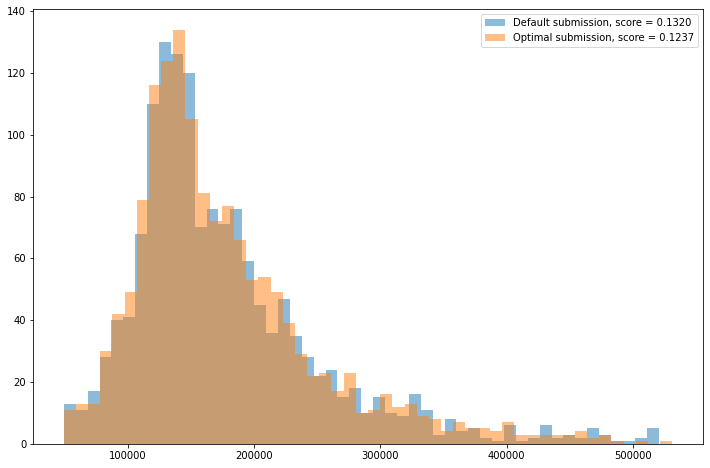

In [68]:
lgb_model_def = lgb.train(lgb_params_def, lgb_train, 1000)
lgb_pred_def = np.exp(yStandardScaler.inverse_transform(lgb_model_def.predict(X_oh)))
lgb_model_opt = lgb.train(lgb_params_opt, lgb_train, 1000)
lgb_pred_opt = np.exp(yStandardScaler.inverse_transform(lgb_model_opt.predict(X_oh)))

lgb_submit_def = np.exp(yStandardScaler.inverse_transform(lgb_model_def.predict(X_submit_oh)))
lgb_submit_opt = np.exp(yStandardScaler.inverse_transform(lgb_model_opt.predict(X_submit_oh)))

submission_df_def = submission_df.copy(deep=True);submission_df_def.SalePrice = lgb_submit_def;submission_df_def.to_csv('Submission_lgb_def.csv',index=False)
# score = 0.13196
submission_df_opt = submission_df.copy(deep=True);submission_df_opt.SalePrice = lgb_submit_opt;submission_df_opt.to_csv('Submission_lgb_opt.csv',index=False)
# score = 0.12375

fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.hist(lgb_submit_def,50,alpha=0.5);
plt.hist(lgb_submit_opt,50,alpha=0.5);
plt.legend(('Default submission, score = {:.4f}'.format(0.13196),'Optimal submission, score = {:.4f}'.format(0.12375)));

print('optimal lightGBM parameters: feature_fraction = {:.3f}, learning_rate = {:.3f}, bagging_fraction = {:.3f}, max_depth = {:.0f}, n_estimators = {:.0f}'
  .format(opt_parameters_lgb[0],opt_parameters_lgb[1],opt_parameters_lgb[2],opt_parameters_lgb[3],opt_parameters_lgb[4]))

We see a significant improvement on the submission score.

#XGBoost
I repeat the procedure for XGBoost - this time I will fit learning_rate, subsample, col_sample_by_tree, max_depth and n_estimators.

In [33]:
import xgboost as xgb
xgb_data = xgb.DMatrix(X_oh, label=y)


# Bounds (NOTE: define continuous variables first, then discrete!)
xgb_bounds = [

    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0.001, .2)},

    {'name': 'subsample',
     'type': 'continuous',
     'domain': (0.1,1)},

    {'name': 'col_sample_by_tree',
     'type': 'continuous',
     'domain': (0.1,1)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': range(3,11)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': range(100, 2000,100)},

]

def f_xgb(parameters):
    # convert parameters vector to a dict    
    xgb_params = {}
    xgb_params['leaning_rate'] = parameters[0][0]
    xgb_params['subsample'] = parameters[0][1]
    xgb_params['col_sample_by_tree'] = parameters[0][2]
    xgb_params['max_depth'] = int(parameters[0][3])
    xgb_params['n_estimators'] = int(parameters[0][4])
    xgb_params['objective'] = 'reg:squarederror'
    xgb_params['random_seed'] = 1234

    score = xgb.cv(xgb_params,xgb_data,nfold=5,num_boost_round=int(parameters[0][4]))
    return score['test-rmse-mean'].iloc[-1]


In [34]:
np.random.seed(777)
xgb_optimizer = GPyOpt.methods.BayesianOptimization(
    f=f_xgb, domain=xgb_bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)


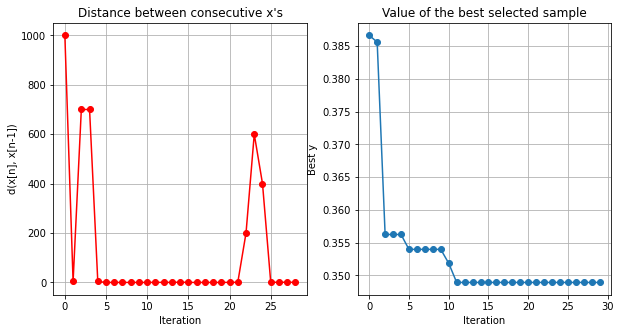

{'learning_rate': 0.03427457938105459, 'subsample': 0.6645407350843145, 'col_sample_by_tree': 0.3070178610817362, 'max_depth': 6, 'n_estimators': 800, 'objective': 'reg:squarederror', 'random_seed': 1234}


In [35]:
max_iter = 50
max_time = 60*60
xgb_optimizer.run_optimization(max_iter, max_time)
xgb_optimizer.plot_convergence()
opt_parameters = xgb_optimizer.X[np.argmin(xgb_optimizer.Y)]

xgb_params_opt = {}
xgb_params_opt['learning_rate'] = opt_parameters[0]
xgb_params_opt['subsample'] = opt_parameters[1]
xgb_params_opt['col_sample_by_tree'] = opt_parameters[2]
xgb_params_opt['max_depth'] = int(opt_parameters[3])
xgb_params_opt['n_estimators'] = int(opt_parameters[4])
xgb_params_opt['objective'] = 'reg:squarederror'
xgb_params_opt['random_seed'] = 1234

xgb_params_def = {}
xgb_params_def['learning_rate'] = 0.1
xgb_params_def['subsample'] = 1
xgb_params_def['col_sample_by_tree'] = 1
xgb_params_def['max_depth'] = 3
xgb_params_def['n_estimators'] = 100
xgb_params_def['objective'] = 'reg:squarederror'
xgb_params_def['random_seed'] = 1234


optimal XGBoost parameters: learning_rate = 0.034, subsample = 0.665, col_sample_by_tree = 0.307,  max_depth = 6, n_estimators = 800


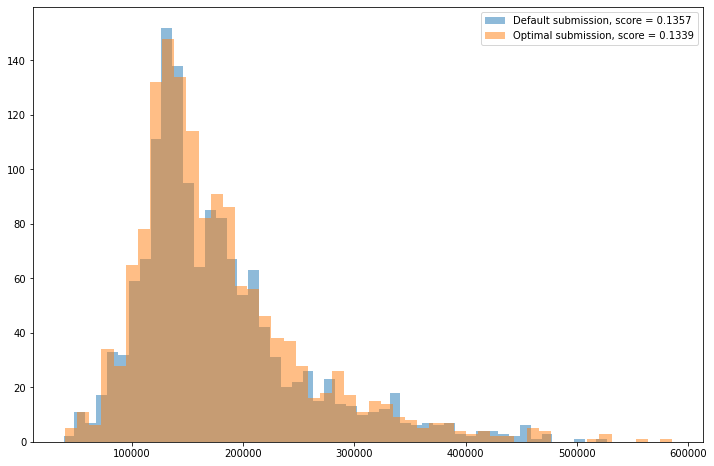

In [72]:
xgb_model_opt = XGBRegressor(objective='reg:squarederror', 
    max_depth=xgb_params_opt['max_depth'],
    n_estimators=xgb_params_opt['n_estimators'],
    subsample=xgb_params_opt['subsample'],
    col_sample_by_tree=xgb_params_opt['col_sample_by_tree'],
    learning_rate=xgb_params_opt['learning_rate'],
    verbose_eval = True)

history_opt = xgb_model_opt.fit(X_oh, y,eval_set=[(X_oh, y)])

xgb_model_def = XGBRegressor(objective='reg:squarederror', 
    max_depth=xgb_params_def['max_depth'],
    n_estimators=xgb_params_def['n_estimators'],
    subsample=xgb_params_def['subsample'],
    col_sample_by_tree=xgb_params_def['col_sample_by_tree'],
    learning_rate=xgb_params_def['learning_rate'],
    verbose_eval = True)

history_def = xgb_model_def.fit(X_oh, y,eval_set=[(X_oh, y)])

xgb_pred_def = np.exp(yStandardScaler.inverse_transform(xgb_model_def.predict(X_oh)))
xgb_pred_opt = np.exp(yStandardScaler.inverse_transform(xgb_model_opt.predict(X_oh)))
xgb_submit_def = np.exp(yStandardScaler.inverse_transform(xgb_model_def.predict(X_submit_oh)))
xgb_submit_opt = np.exp(yStandardScaler.inverse_transform(xgb_model_opt.predict(X_submit_oh)))

submission_df_def = submission_df.copy(deep=True);submission_df_def.SalePrice = xgb_submit_def;submission_df_def.to_csv('Submission_xgb_def.csv',index=False)
# score = 0.13573
submission_df_opt = submission_df.copy(deep=True);submission_df_opt.SalePrice = xgb_submit_opt;submission_df_opt.to_csv('Submission_xgb_opt.csv',index=False)
# score = 0.13389

fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.hist(xgb_submit_def,50,alpha=0.5);
plt.hist(xgb_submit_opt,50,alpha=0.5);
plt.legend(('Default submission, score = {:.4f}'.format(0.13573),'Optimal submission, score = {:.4f}'.format(0.13389)));
print('optimal XGBoost parameters: learning_rate = {:.3f}, subsample = {:.3f}, col_sample_by_tree = {:.3f}, max_depth = {:.0f}, n_estimators = {:.0f}'
  .format(xgb_params_opt['learning_rate'],
          xgb_params_opt['subsample'],
          xgb_params_opt['col_sample_by_tree'],
          xgb_params_opt['max_depth'],
          xgb_params_opt['n_estimators']))


We get a smaller improvement this time. 

# Random forest regressor
I optimize for min_sample_split, min_sample_leaf, max_depth and n_estimators.

In [132]:
# Bounds (NOTE: define continuous variables first, then discrete!)
from sklearn.model_selection import cross_val_score
rf_bounds = [

    {'name': 'min_sample_split',
     'type': 'discrete',
     'domain': range(2, 20)},

    {'name': 'min_sample_leaf',
     'type': 'discrete',
     'domain': range(1,10)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': range(3,11)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': range(100, 2000,100)},

]
parameters = [rf_opt_parameters]
def f_rf(parameters):
    min_samples_split = int(parameters[0][0])
    min_samples_leaf = int(parameters[0][1])
    max_depth = int(parameters[0][2])
    n_estimators = int(parameters[0][3])
    clf = RandomForestRegressor(n_estimators = n_estimators,                                  
                                 criterion='mse', 
                                 random_state = 42,
                                 max_depth=max_depth,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 n_jobs=-1)
    score = cross_val_score(clf, X_oh, y, cv=5)

    return np.sqrt(np.mean(score**2))

In [133]:
np.random.seed(777)
rf_optimizer = GPyOpt.methods.BayesianOptimization(
    f=f_rf, domain=rf_bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)


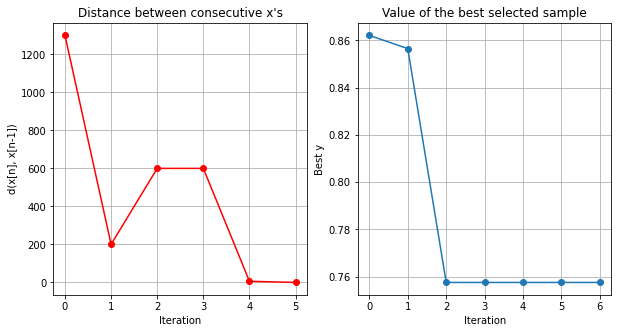

In [134]:
max_iter = 50
max_time = 60*60
rf_optimizer.run_optimization(max_iter, max_time)
rf_optimizer.plot_convergence()

rf_opt_parameters = rf_optimizer.X[np.argmin(rf_optimizer.Y)]
rf_params_def = [2,1,3,100]



optimal random forest parameters: min_sample_split = 8.000, min_sample_leaf = 9.000, max_depth = 3, n_estimators = 800


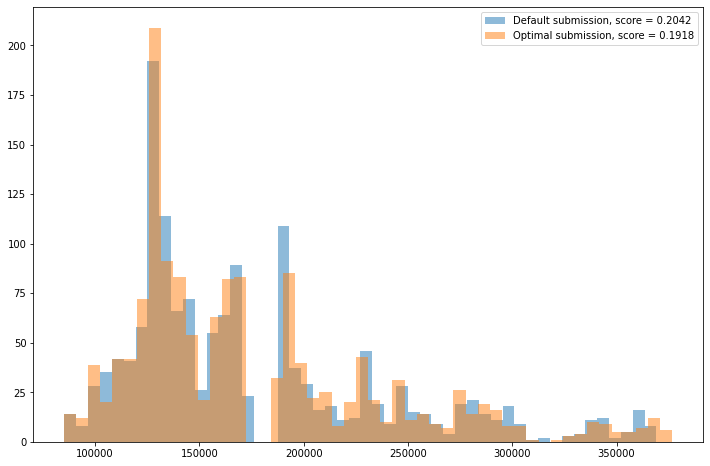

In [139]:
clf_opt = RandomForestRegressor(n_estimators = int(rf_opt_parameters[3]),                                  
                                criterion='mse', 
                                random_state = 42,
                                max_depth=int(rf_opt_parameters[2]),
                                min_samples_split = int(rf_opt_parameters[0]),
                                min_samples_leaf = int(rf_opt_parameters[1]),
                                n_jobs=-1)

clf_def = RandomForestRegressor(n_estimators = int(rf_params_def[3]),                                  
                                criterion='mse', 
                                random_state = 42,
                                max_depth=int(rf_params_def[2]),
                                min_samples_split = rf_params_def[0],
                                min_samples_leaf = rf_params_def[1],
                                n_jobs=-1)

clf_opt.fit(X_oh,y)
clf_def.fit(X_oh,y)

rf_pred_opt = np.exp(yStandardScaler.inverse_transform(clf_opt.predict(X_oh)))
rf_pred_def = np.exp(yStandardScaler.inverse_transform(clf_def.predict(X_oh)))
rf_submit_def = np.exp(yStandardScaler.inverse_transform(clf_def.predict(X_submit_oh)))
rf_submit_opt = np.exp(yStandardScaler.inverse_transform(clf_opt.predict(X_submit_oh)))

submission_df_def = submission_df.copy(deep=True);submission_df_def.SalePrice = rf_submit_def;submission_df_def.to_csv('Submission_rf_def.csv',index=False)
# score = 0.20417
submission_df_opt = submission_df.copy(deep=True);submission_df_opt.SalePrice = rf_submit_opt;submission_df_opt.to_csv('Submission_rf_opt.csv',index=False)
# score = 0.20261


fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.hist(rf_submit_def,50,alpha=0.5);
plt.hist(rf_submit_opt,50,alpha=0.5);
plt.legend(('Default submission, score = {:.4f}'.format(0.20417),'Optimal submission, score = {:.4f}'.format(0.19175)));

print('optimal random forest parameters: min_sample_split = {:.3f}, min_sample_leaf = {:.3f}, max_depth = {:.0f}, n_estimators = {:.0f}'
  .format(rf_opt_parameters[0],rf_opt_parameters[1],rf_opt_parameters[2],rf_opt_parameters[3]))

A slight improvement but both scores are poor.

# [CatBoost](https://catboost.ai/)

Next I look at CatBoost, an implementation of gradient boosting that automatically handels categorical features. Note that I pass in the DataFrame X as training data, rather that the one-hot encoded version that I use in all the other models. I tune learning_rate, l2_leaf_ref, depth and n_estimators.

In [56]:
# Bounds (NOTE: define continuous variables first, then discrete!)
cat_boost_bounds = [

    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0.001, .1)},

    {'name': 'l2_leaf_reg',
     'type': 'continuous',
     'domain': (1, 10)},

    {'name': 'depth',
     'type': 'discrete',
     'domain': range(3,11)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': range(100, 2000,100)},

]

cat_boost_data = Pool(data=X, label=y,
                  cat_features=cat_boost_categorical_features)


def f_cat_boost(parameters):
  cat_boost_params = {}
  cat_boost_params['learning_rate'] = parameters[0][0]
  cat_boost_params['l2_leaf_reg'] = parameters[0][1]
  cat_boost_params['depth'] = parameters[0][2]
  cat_boost_params['n_estimators'] = parameters[0][3]
  cat_boost_params['loss_function'] ='RMSE'
  # cat_boost_params['verbose_eval'] = False
  score = cat_boost_cv(cat_boost_data,params=cat_boost_params,nfold=5)

  return score['test-RMSE-mean'].min()


In [ ]:
np.random.seed(777)
optimizer_cat_boost = GPyOpt.methods.BayesianOptimization(
    f=f_cat_boost, domain=cat_boost_bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)


In [ ]:
max_iter = 50
max_time = 60*60
optimizer_cat_boost.run_optimization(max_iter, max_time)

optimizer_cat_boost.plot_convergence()
opt_parameters_cat_boost = optimizer_cat_boost.X[np.argmin(optimizer_cat_boost.Y)]


optimal random forest parameters: learning_rate = 0.050, l2_leaf_reg = 9.912,  depth = 10, n_estimators = 800


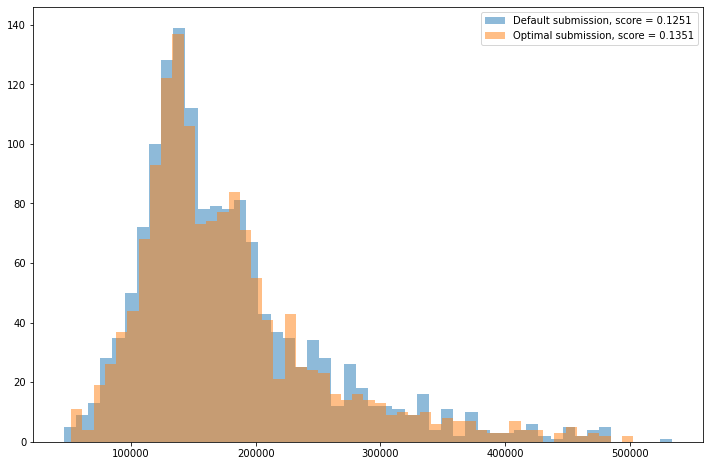

In [75]:
cat_boost_opt =CatBoostRegressor(iterations=int(opt_parameters_cat_boost[3]),
                                 depth=int(opt_parameters_cat_boost[2]),
                                 learning_rate=opt_parameters_cat_boost[0],
                                 l2_leaf_reg=opt_parameters_cat_boost[1],
                                 loss_function='RMSE')

cat_boost_opt.fit(X, y,cat_features=cat_boost_categorical_features)

cat_boost_def =CatBoostRegressor(iterations=1000,
                                 depth=6,
                                 l2_leaf_reg=3,
                                 loss_function='RMSE')

cat_boost_def.fit(X, y,cat_features=cat_boost_categorical_features)

cb_pred_opt = np.exp(yStandardScaler.inverse_transform(cat_boost_opt.predict(X)))
cb_pred_def = np.exp(yStandardScaler.inverse_transform(cat_boost_def.predict(X)))
cb_submit_def = np.exp(yStandardScaler.inverse_transform(cat_boost_def.predict(X_submit)))
cb_submit_opt = np.exp(yStandardScaler.inverse_transform(cat_boost_opt.predict(X_submit)))

submission_df_def = submission_df.copy(deep=True);submission_df_def.SalePrice = cb_submit_def;submission_df_def.to_csv('Submission_cb_def.csv',index=False)
# score = 0.12508
submission_df_opt = submission_df.copy(deep=True);submission_df_opt.SalePrice = cb_submit_opt;submission_df_opt.to_csv('Submission_cb_opt.csv',index=False)
# score = 0.13515

fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.hist(cb_submit_def,50,alpha=0.5);
plt.hist(cb_submit_opt,50,alpha=0.5);
plt.legend(('Default submission, score = {:.4f}'.format(0.12508),'Optimal submission, score = {:.4f}'.format(0.13515)));

print('optimal random forest parameters: learning_rate = {:.3f}, l2_leaf_reg = {:.3f}, depth = {:.0f}, n_estimators = {:.0f}'
  .format(opt_parameters_cat_boost[0],opt_parameters_cat_boost[1],opt_parameters_cat_boost[2],opt_parameters_cat_boost[3]))



#Neural Network

Finally a neural network. There are many ways to set up a neural network and there is no default parametrization as such, but I will try anyway. The model I chose can have up to 4 fully dense layers each followed by a dropout layer. I will let the optimizer chose the number of layers and the number of neurons in each layer, plus the dropout rates, the learning rate and the number of epochs, so a total of 11 parameter, 10 of them discrete.

If the number of layers is less than four however, some of the parameters will become redundant - for example if no_layers = 3 then layer4_size and dropout4 will not be used so changing them will not affect the objective value. This seems inefficient but I couldn't see any other way to do it - in any case the optimization runs reasonable quickly.

In [49]:
from sklearn.model_selection import KFold
# Bounds (NOTE: define continuous variables first, then discrete!)
nn_bounds = [

    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0.001,0.1)},

    {'name': 'no_layers',
     'type': 'discrete',
     'domain': range(4)},

    {'name': 'layer1_size',
     'type': 'discrete',
     'domain': range(0, 128,16)},

    {'name': 'dropout_1',
     'type': 'discrete',
     'domain': np.arange(0, 5)*0.1},    

    {'name': 'layer2_size',
     'type': 'discrete',
     'domain': range(0, 128,16)},

    {'name': 'dropout_2',
     'type': 'discrete',
     'domain': np.arange(0, 5)*0.1},    

    {'name': 'layer3_size',
     'type': 'discrete',
     'domain': range(0, 128,16)},

    {'name': 'dropout_3',
     'type': 'discrete',
     'domain': np.arange(0, 5)*0.1},    

    {'name': 'layer4_size',
     'type': 'discrete',
     'domain': range(0, 128,16)},
     
    {'name': 'dropout_4',
     'type': 'discrete',
     'domain': np.arange(0, 5)*0.1},    

    {'name': 'epochs',
     'type': 'discrete',
     'domain': range(10,100,10)},

]
parameters = [[0.1,1,64,0.1,64,0.1,32,0.2,16,0.1,100]]

def create_model(parameters):
  learning_rate = parameters[0][0]
  no_layers = int(parameters[0][1])
  no_epochs = int(parameters[0][-1])

  tf.random.set_seed(1234)
  nn_model = Sequential()
  for i in range(no_layers):
    size = int(parameters[0][2*(i+1)])
    dropout = parameters[0][2*(i+1)+1]
    if i == 0:
      nn_model.add(Dense(size, input_dim=X_oh.shape[1],kernel_initializer='normal', activation='relu'))
    else:
      nn_model.add(Dense(size, kernel_initializer='normal', activation='relu'))
    nn_model.add(Dropout(dropout))
  nn_model.add(Dense(1, kernel_initializer='normal'))
  nn_model.compile(loss='mean_squared_error', optimizer='adam')
  return nn_model

def f_nn(parameters):
  nn_model = create_model(parameters)
  kf = KFold(n_splits=5)
  kf.get_n_splits(X)
  score = 0
  no_epochs = int(parameters[0][-1])

  for train_index, test_index in kf.split(X):
    history = nn_model.fit(X_oh[train_index],y[train_index],
                           batch_size=64,
                           epochs=no_epochs, 
                           validation_data=(X_oh[test_index], y[test_index]),
                           verbose=False)
    score = score + history.history['val_loss'][-1]
  return score / 5


In [50]:
np.random.seed(777)
optimizer_nn = GPyOpt.methods.BayesianOptimization(
    f=f_nn, domain=nn_bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)


In [ ]:
max_iter = 50
max_time = 60*60
optimizer_nn.run_optimization(max_iter, max_time)

optimizer_nn.plot_convergence()
opt_parameters_nn = optimizer_nn.X[np.argmin(optimizer_nn.Y)]



optimal neural network parameters: learning_rate = 0.001, no_layers = 3, layer1_size = 112, dropout1 = 0
layer2_size = 64, dropout2 = 0, layer3_size = 0, dropout3 = 0,layer4_size = 48, dropout4 = 0, epochs = 60


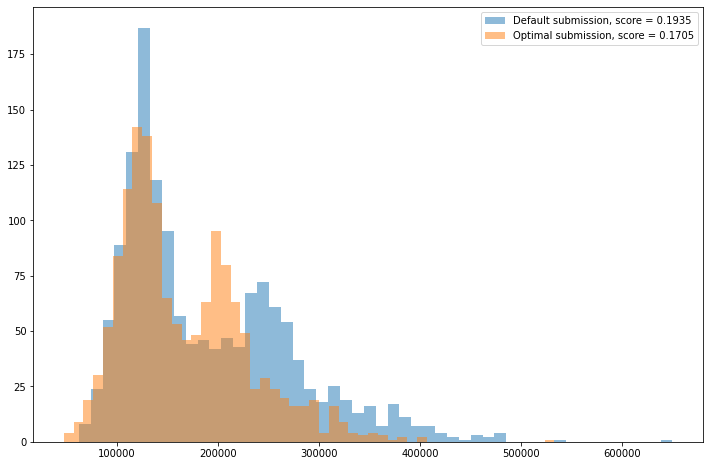

In [78]:
nn_opt =create_model([opt_parameters_nn])
nn_opt.fit(X_oh, y)
nn_pred_opt = np.exp(yStandardScaler.inverse_transform(nn_opt.predict(X_oh)))

nn_def =create_model([[0.001,4,128,0,64,0,32,0,16,0,10]])
nn_def.fit(X_oh, y)
nn_pred_def = np.exp(yStandardScaler.inverse_transform(nn_def.predict(X_oh)))

nn_submit_def = np.exp(yStandardScaler.inverse_transform(nn_def.predict(X_submit_oh)))
nn_submit_opt = np.exp(yStandardScaler.inverse_transform(nn_opt.predict(X_submit_oh)))

submission_df_def = submission_df.copy(deep=True);submission_df_def.SalePrice = nn_submit_def;submission_df_def.to_csv('Submission_nn_def.csv',index=False)
# score = 0.19346
submission_df_opt = submission_df.copy(deep=True);submission_df_opt.SalePrice = nn_submit_opt;submission_df_opt.to_csv('Submission_nn_opt.csv',index=False)
# score = 0.17051

fig,ax = plt.subplots(1,1,figsize=(12,8))
plt.hist(nn_submit_def,50,alpha=0.5);
plt.hist(nn_submit_opt,50,alpha=0.5);
plt.legend(('Default submission, score = {:.4f}'.format(0.19346),'Optimal submission, score = {:.4f}'.format(0.17051)));

print('optimal neural network parameters: learning_rate = {:.3f}, no_layers = {:.0f}, layer1_size = {:.0f}, dropout1 = {:.0f}'
  .format(opt_parameters_nn[0],opt_parameters_nn[1],opt_parameters_nn[2],opt_parameters_nn[3]))
print('layer2_size = {:.0f}, dropout2 = {:.0f}, layer3_size = {:.0f}, dropout3 = {:.0f},layer4_size = {:.0f}, dropout4 = {:.0f}, epochs = {:.0f}'
  .format(opt_parameters_nn[4],opt_parameters_nn[5],opt_parameters_nn[5],opt_parameters_nn[7],opt_parameters_nn[8],opt_parameters_nn[9],opt_parameters_nn[10]))


I get quite a large improvement this time, but as with Random Forest, neither score is impressive.

#Conclusion

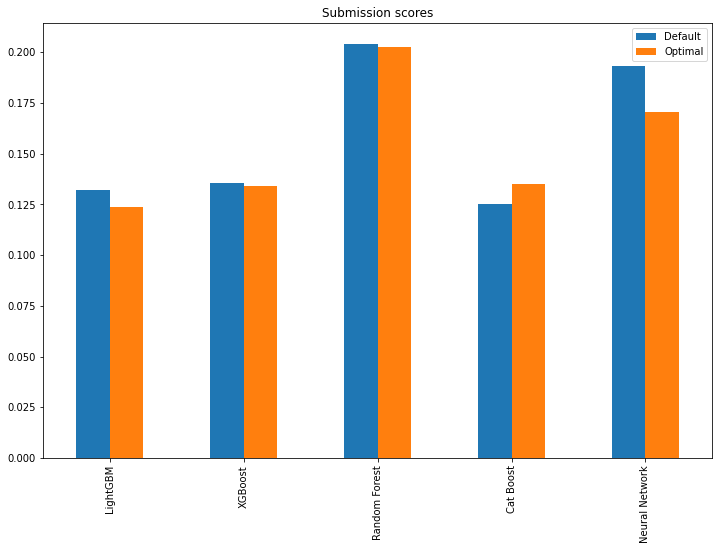

In [140]:
data=np.array([[0.13196,0.12375],[0.13573,0.13389],[0.20417,0.20261-],[0.12508,0.13515],[0.19346,0.17051]])

fig,ax = plt.subplots(1,1,figsize=(12,8))
scores_df = pd.DataFrame(index = ['LightGBM','XGBoost','Random Forest','Cat Boost','Neural Network'],
                         columns=['Default','Optimal'],
                         data=data)
scores_df.plot(kind='bar',ax=ax);
plt.title('Submission scores');

In all but one of the cases the hyperparameter tuning leads to an improved solution so it is certainly a worthwhile exercise. 

The only algorithm which I failed to improve was CatBoost which actually took the longest to optimize. 
This lends support to the [claim](https://catboost.ai/):

*Great quality without parameter tuning - 
Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters.*

In fact only one of the models (the optimized version of LightGBM) has a better submission score.

One of the benefits of a systematic approach to hyperparameter tuning is that it removes any subjectivity from model selection. 
For example, imagine that you have constructed two sets of training features for a prediction problem and you want to test the hypothesis that Set A allows us to make better predictions that Set B. You could test the hypothesis by fitting your preferred ML algorithm on each set and comparing the validation loss of each fit. However model will perform best with different hyperparameters and how can we be sure that we have not (perhaps subconciously) tried a bit harder to fit optimal hyperparameters for you preferred feature set. A systematic approach removes any potential bias.



Even with this algorithm there is still a lot of work to be done is chosing which of the sometimes bewildering array of hyperparameters to fit and deciding what are reasonable bounds, so it is still necessary to have a good intuiton for how an alogrithm works, whether it is overfitting or underfitting and how it can be improved.